---

<h1><center><br> K-means clustering </center></h1>

---

In [1]:
result = {}

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats

# 1) Load the data
Use `pickle.load` to load `Data.pickle`. This file contains a single matrix called `X`. Use variables `N` and `D` for the number of rows (samples) and columns (features) respectively. 

In [15]:
with open('Data.pickle','rb') as file:
    X = pickle.load(file)
    
N = X.shape[0]
D = X.shape[1]

# 2) Scatter plot
Create a scatter plot with the first column along the x-axis and the second column along the y-axis. We will use `plt.axis('equal')` to force the two axes to have the same scale. This is important for correct visualization of the Euclidean distances between points. 

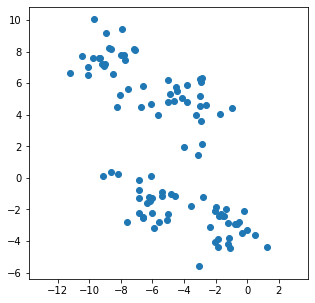

In [16]:
fig2 = plt.figure(figsize=(5,5))

plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')

plt.show()

# 3) Initialize centroids
We will write a function that takes the number of centroids `K` and the data matrix `X` and returns `K` randomly placed centroids. The centroids should be selected according to a uniform distribution that spans a box fitted to the data. The return value should be a numpy array with shape `(K,D)` where `D` is the number of columns in X. 

In [17]:
result['fig2'] = fig2

In [22]:
def initialize_centroids(K,X):
    
    D = X.shape[1]
    
    # Define lower and upper bounds of uniform distribution by the min and max values in the dataset
    uL = np.min(X, axis = 0)
    uU = np.max(X, axis = 0)
    
    # Generate K random centroids from the defined uniform distribution
    C = stats.uniform.rvs(uL, uU - uL, (K, D))
    
    return C

# 4) Compute the assignment for given centroids
We will write a function that takes the data matrix and centroid locations, and returns an assignment matrix `r`. `r` should be a numpy array with shape `(N,K)`. Each row of `r` should contain `K-1` `False` values and one `True` value in the position corresponding to the centroid that is nearest to that data point (Euclidean distance). 

In [23]:
result['C3'] = initialize_centroids(3,X)

In [24]:
def assign_samples_to_nearest_centroid(X,C):
    N = X.shape[0]
    K = C.shape[0]
    r = np.zeros((N, K), dtype = 'bool')
    
    check = False
    while not check == True :
        for n in range(N): 
            dist = np.linalg.norm(X[n] - C, axis = 1)
            r[n, np.argmin(dist)] = True

        # Check if the assignment is valid
        if not np.any(r, axis = 0).all() == True:
            check = False
            C = initialize_centroids(K,X)
        else:
            check = True
                
    
    return r

# 5) Plot data, centroids, assignment
We will write a function that takes the data matrix, a set of centroids, and an assignment matrix and creates a scatter plot similar to the one shown here. The centroids should be indicated with a large dot, and the data samples should be color-coded according to their cluster membership. 

In [25]:
result['r4'] = assign_samples_to_nearest_centroid(X,result['C3'])

In [26]:
def plot_scatter(X, C, r):
    K = r.shape[1]
    fig = plt.figure(figsize=(5,5))
    
    for k in range(K): 
        plt.scatter(X[r[:, k], 0], X[r[:, k], 1], 20)
    
    plt.scatter(C[:, 0], C[:, 1], 100)
    
    plt.axis('equal')
    
    return fig

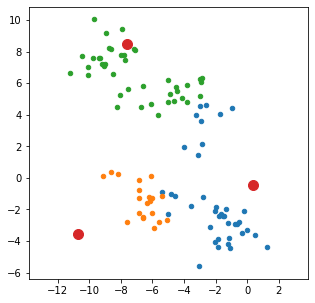

In [27]:
result['fig5'] = plot_scatter(X, result['C3'], result['r4'])

# 6) Compute the centroids for a given assignment
We will write a function that takes the assignment and the data matrix and returns centroids placed at the mean of each cluster. The return value should be a numpy array with shape `(K,D)`.

In [28]:
def place_centroids(r, X):
    K = r.shape[1]
    D = X.shape[1]
    C = np.empty((K,D))
    
    for k in range(K): 
        C[k, :] = np.mean(X[r[:, k]], axis = 0)
    
    return C

# 7) Code simple k-means
Now we will use some of the functions we've developed to code the full k-means algorithm. 

In [37]:
result['C6'] = place_centroids(result['r4'], X)

In [38]:
def run_kmeans(X,C):

    done = False
    first = True
    
    while not done:

        r = assign_samples_to_nearest_centroid(X,C)
        C = place_centroids(r, X)

        if first == False and np.all(r == rold): 
            break
            
        rold = r
        first = False

    return C, r

In [39]:
result['kmeans7'] = run_kmeans(X,result['C3'])

# 8) Evaluate the cost function 
We will write a functionthat evaluates the intertia for a given data matrix, centroid placement, and assignment matrix. The result is a scalar value. 

In [40]:
def eval_cost(X,C,r):
    K = r.shape[1]
    
    cost = 0.0
    for k in range(K):
        dist = np.linalg.norm(X[r[:, k], :] - C[k, :], axis = 1)
        cost = cost + np.sum(dist**2)
    
    return cost

In [41]:
result['cost8'] = eval_cost(X,result['C3'],result['r4'])

# 9) Ensemble run
We will write a function that runs kmeans `ensemblesize` times, each with a different initial centroid placement. These initial placements should be chosen with `initialize_centroids(K,X)`. The function should return the single run with the lowest cost. Results should be returned in a **dictionary** with keys `('C','r','cost')`. `C` are the best centroids, `r` is the best assignment, and `cost` is the corresponding cost. 

In [35]:
def ensemble_run(K,X,ensemblesize):
    best_run = {'C':None,'r':None,'cost':None}
    for e in range(ensemblesize):
        
        C = initialize_centroids(K,X)
        C, r = run_kmeans(X,C)
        cost = eval_cost(X,C,r)
        
        if best_run['cost'] == None:
            best_run['C'] = C
            best_run['r'] = r
            best_run['cost'] = cost
        else:
            if cost < best_run['cost']:
                best_run['C'] = C
                best_run['r'] = r
                best_run['cost'] = cost
    
    return best_run

In [36]:
result['ens9'] = ensemble_run(3,X,100)

# 10) Iteration over K
We will write a function that takes the data matrix, a sample size, and a maximum number of clusters to consider (`maxK`).  The function should run `ensemble_run` for all values of `K` from 1 to `maxK`. It should return a numpy array of length `maxK` with the best case cost for each value of `K`. (6 pts)

In [42]:
def K_iteration(X, ensemblesize, maxK):
    allK = list(range(1, maxK + 1))
    best_cost = np.empty(len(allK))
    
    for k in allK: 
        best_cost[k - 1] = ensemble_run(k, X, ensemblesize)['cost']
    
    return best_cost

# 11) Selecting K

We now run `K_iteration` with `ensemblesize=200`, `maxK=10` and plot the result. The plot shows the percent improvement of each `K` over `K-1`. From this plot, choose an ideal value for `K` and report it in the results dictionary as `Kideal`. 

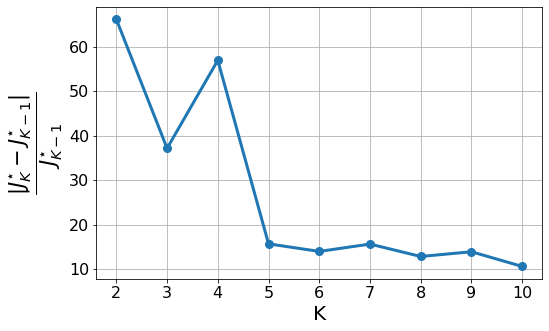

In [43]:
ensemblesize = 200
maxK = 10
best_cost = K_iteration(X, ensemblesize, maxK)

fig11 = plt.figure(figsize = (8,5))
allK = list(range(1, maxK + 1))

plt.plot(allK[1:], 100 * np.abs(np.diff(best_cost)) / best_cost[:-1],
         linewidth=3,
         marker='o',
         markersize=8)

plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$\frac {|J_{K}^{\star}-J_{K-1}^{\star}|} {J_{K-1}^{\star}}$', fontsize = 30)
plt.xlabel('K', fontsize = 20)
plt.show()

In [45]:
Kideal = 4

In [47]:
result['fig11'] = fig11
result['Kideal'] = Kideal